In [1]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from tqdm import tqdm
from PIL import Image, ImageDraw, ImageFont
import pandas as pd
import numpy as np
import math
import cv2
import os
import copy
from scipy import ndimage
from scipy.spatial import ConvexHull
from joblib import Parallel, delayed
from skimage.morphology import convex_hull_image, binary_closing, square, dilation

In [2]:
#  load all images from a directory
def load_images_from_folder(folder):
    images = []
    filenames = []
    for filename in tqdm(os.listdir(folder)):
        try:
            img = Image.open(os.path.join(folder,filename))
            if img is not None:
                if img.mode != 'RGB':
                    img = img.convert('RGB')
                img = np.array(img)
                images.append(img)
                filenames.append(filename)
        except Exception as e:
            print(e)
    return images, filenames

In [3]:
# load all jsons from a directory
def load_jsons_from_folder(folder):
    jsons = []
    filenames = []
    for filename in tqdm(os.listdir(folder)):
        try:
            json = pd.read_json(os.path.join(folder,filename))
            if json is not None:
                jsons.append(json)
                filenames.append(filename)
        except Exception as e:
            print(e)
    return jsons, filenames

In [4]:
LOAD_CLEAN = False
if LOAD_CLEAN:
    human_parsing = load_images_from_folder('Task/dataset/human_parsing')
    image = load_images_from_folder('Task/dataset/image')
    pose_img = load_images_from_folder('Task/dataset/pose_img')
    pose_json = load_jsons_from_folder('Task/dataset/pose_json')
    df = pd.DataFrame()
    df['image'] = image[0]
    df['human_parsing'] = human_parsing[0]
    df['pose_img'] = pose_img[0]
    df['pose_json'] = pose_json[0]
    df['ids'] = [a.split('.')[0] for a in image[1]]
    df['pose_keypoints'] = df.pose_json.apply(lambda x: x.people[0].get('pose_keypoints_2d'))
    left_ankles = [a[3*11:3*12-1] for a in tqdm(df.pose_keypoints)]
    right_ankles = [a[3*14:3*15-1] for a in tqdm(df.pose_keypoints)]
    df['left_ankles'] = left_ankles
    df['right_ankles'] = right_ankles
    df.to_pickle('df.pkl')
else:
    df = pd.read_pickle('df.pkl')

In [5]:
def get_color_mask(img, colors):
    mask = np.zeros(img.shape[:2], dtype=np.uint8)
    for color in colors:
        mask += np.all(img == color, axis=-1).astype(np.uint8)
    return mask

def clean_outliers(mask):
    labels, num_labels = ndimage.label(mask)
    component_sizes = ndimage.sum(mask, labels, range(num_labels + 1))
    mask_largest_component = (labels == component_sizes.argmax())
    return mask_largest_component

def apply_mask(img, mask):
    img = np.array(img)
    img[mask] = (128, 128, 128)
    return Image.fromarray(img)

def ankle_mask(img, left_ankle, right_ankle):
    try:
        img = np.array(img)
        mask = np.zeros(img.shape[:2], dtype=np.uint8)
        x = [left_ankle[0], right_ankle[0]]
        y = [left_ankle[1], right_ankle[1]]
        m = (y[1] - y[0]) / (x[1] - x[0])
        b = y[0] - m * x[0]
        for i in range(img.shape[0]):
            for j in range(img.shape[1]):
                if i > m * j + b:
                    mask[i, j] = 1
        return mask
    except Exception as e:
        print(e)
        return np.zeros(img.shape[:2], dtype=np.uint8)

In [6]:
short_colors = {(64, 0, 128), (192, 0, 0)}
legs_colors = {(128,64,0), (0,64,0)}

shirt_colors = {(128,0,128), (128,128,128), (128,64,128)}
hands_colors = {(192,128,128),(64,128,128)}

In [7]:
RENDER = False
if RENDER:
    tqdm._instances.clear()
    # mask_shorts = [get_color_mask(a, short_colors) for a in tqdm(human_parsing[0])]
    # mask_shorts_clean = [clean_outliers(a) for a in tqdm(mask_shorts)]
    # mask_legs = [get_color_mask(a, legs_colors) for a in tqdm(human_parsing[0])]
    # mask_shirts = [get_color_mask(a, shirt_colors) for a in tqdm(human_parsing[0])]
    # mask_hands = [get_color_mask(a, hands_colors) for a in tqdm(human_parsing[0])]
    # mask_ankle = [ankle_mask(a, b, c) for a, b, c in tqdm(zip(df.image, df.left_ankles, df.right_ankles))]

    # parallel mask_shorts
    mask_shorts = Parallel(n_jobs=-1)(delayed(get_color_mask)(a, short_colors) for a in tqdm(df.human_parsing))
    mask_shorts_clean = Parallel(n_jobs=-1)(delayed(clean_outliers)(a) for a in tqdm(mask_shorts))
    mask_legs = Parallel(n_jobs=-1)(delayed(get_color_mask)(a, legs_colors) for a in tqdm(df.human_parsing))
    mask_shirts = Parallel(n_jobs=-1)(delayed(get_color_mask)(a, shirt_colors) for a in tqdm(df.human_parsing))
    mask_hands = Parallel(n_jobs=-1)(delayed(get_color_mask)(a, hands_colors) for a in tqdm(df.human_parsing))
    mask_ankle = Parallel(n_jobs=-1)(delayed(ankle_mask)(a, b, c) for a, b, c in tqdm(zip(df.image, df.left_ankles, df.right_ankles)))

    
    df['mask_shorts'] = mask_shorts
    df['mask_legs'] = mask_legs
    df['mask_shirts'] = mask_shirts
    df['mask_hands'] = mask_hands
    df['mask_ankle'] = mask_ankle
    df.to_pickle('df_full.pkl')
else:
    df = pd.read_pickle('df_full.pkl')

In [8]:
def line_intersection(line1, line2):
    xdiff = (line1[0][0] - line1[1][0], line2[0][0] - line2[1][0])
    ydiff = (line1[0][1] - line1[1][1], line2[0][1] - line2[1][1])

    def det(a, b):
        return a[0] * b[1] - a[1] * b[0]

    div = det(xdiff, ydiff)
    if div == 0:
       raise Exception('lines do not intersect')

    d = (det(*line1), det(*line2))
    x = det(d, xdiff) / div
    y = det(d, ydiff) / div
    return x, y

def order_points(pts):
    # initialzie a list of coordinates that will be ordered
    # such that the first entry in the list is the top-left,
    # the second entry is the top-right, the third is the
    # bottom-right, and the fourth is the bottom-left
    rect = np.zeros((4, 2), dtype = "float32")

    # the top-left point will have the smallest sum, whereas
    # the bottom-right point will have the largest sum
    s = pts.sum(axis = 1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]

    # now, compute the difference between the points, the
    # top-right point will have the smallest difference,
    # whereas the bottom-left will have the largest difference
    diff = np.diff(pts, axis = 1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]

    # return the ordered coordinates
    return rect

def get_box(mask):
    mask = convex_hull_image(clean_outliers(mask))
    box = cv2.goodFeaturesToTrack(
        mask.astype(np.uint8), 
        maxCorners=4, 
        minDistance=20, 
        blockSize=20,
        qualityLevel=0.001)
    box = np.array([a[0] for a in box])
    box = order_points(box)
    box = np.int0(box)
    return box
    # top_left, top_right, bottom_right, bottom_left = box

def prolong_shorts(shorts, left_ankle, right_ankle):
    try:
        top_left, top_right, bottom_right, bottom_left = get_box(shorts)

        ankle_line = ((left_ankle[0], left_ankle[1]), (right_ankle[0], right_ankle[1]))

        left_line = ((top_left[0], top_left[1]), (bottom_left[0], bottom_left[1]))
        left_intersection = line_intersection(left_line, ankle_line)

        right_line = ((top_right[0], top_right[1]), (bottom_right[0], bottom_right[1]))
        right_intersection = line_intersection(right_line, ankle_line)

        mask = Image.fromarray(np.zeros(shorts.shape, dtype=np.uint8))
        draw = ImageDraw.Draw(mask)
        # draw.polygon([tuple(top_left), tuple(top_right), tuple(bottom_right), tuple(bottom_left)], outline=1, fill=1)

        draw.polygon([tuple(top_left), tuple(left_intersection), tuple(right_intersection), tuple(top_right)], outline=1, fill=1)
        mask = np.array(mask)
        mask = mask
        return mask
    except Exception as e:
        print(e)
        return None

# N = 36
# imshow(prolong_shorts(df.mask_shorts[N], df.left_ankles[N], df.right_ankles[N]))

In [9]:
# top_left, top_right, bottom_right, bottom_left
tqdm._instances.clear()
boxes_shorts = Parallel(n_jobs=-1)(
    delayed(get_box)(a) for a in tqdm(df.mask_shorts)
)
df['boxes_shorts'] = boxes_shorts

100%|██████████| 704/704 [00:16<00:00, 43.28it/s]


In [10]:
tqdm._instances.clear()
mask_prolonged_shorts = Parallel(n_jobs=14)(
    delayed(prolong_shorts)(a, b, c) for a, b, c in tqdm(zip(df.mask_shorts, df.left_ankles, df.right_ankles))
)
df['mask_prolonged_shorts'] = mask_prolonged_shorts

704it [00:14, 48.39it/s]


In [11]:
IMGSIZE = df.image[0].shape[0:2]
IMGSIZE

(1024, 768)

In [12]:
ANKLE_DISTANCE_X = 100
ANKLE_DISTANCE_Y = 50
df['left_ankles_anchors'] = df.left_ankles.apply(lambda x: (x[0]-ANKLE_DISTANCE_X, x[1]-ANKLE_DISTANCE_Y))
df['right_ankles_anchors'] = df.right_ankles.apply(lambda x: (x[0]+ANKLE_DISTANCE_X, x[1]-ANKLE_DISTANCE_Y))
# switch left_ankles_anchors and right_ankles_anchors if x[0] of left is bigger than x[0] of right
df['left_ankles_anchors'], df['right_ankles_anchors'] = np.where(
    df.left_ankles_anchors.apply(lambda x: x[0]) < df.right_ankles_anchors.apply(lambda x: x[0]),
    [df.right_ankles_anchors, df.left_ankles_anchors],
    [df.left_ankles_anchors, df.right_ankles_anchors]
)

In [13]:
def mask_from_point(point):
    mask = np.zeros(IMGSIZE, dtype=np.uint8)
    point = np.int0(point)
    mask[point[1], point[0]] = 1
    return mask

In [14]:
df['mask_left_ankle'] = [mask_from_point(a) for a in df.left_ankles_anchors]
df['mask_right_ankle'] = [mask_from_point(a) for a in df.right_ankles_anchors]

In [15]:
tqdm._instances.clear()
mask_shorts_ankles = Parallel(n_jobs=-1)(
    delayed(convex_hull_image)(a + b + c) for a, b, c in tqdm(zip(df.mask_shorts, df.mask_left_ankle, df.mask_right_ankle))
)

704it [00:04, 143.99it/s]


In [16]:
df['mask_shorts_ankles'] = mask_shorts_ankles

In [17]:
df['mask_shorts_ankles_legs'] = df.mask_shorts_ankles + df.mask_legs

In [18]:
df.mask_shirts = df.mask_shirts.apply(lambda x: x.astype(np.bool_))
df.mask_hands = df.mask_hands.apply(lambda x: x.astype(np.bool_))

df['mask_final'] = df.mask_shorts_ankles_legs *~ df.mask_shirts *~ df.mask_hands

In [19]:
def get_by_id(df, id):
    return df[df.ids.str.contains(str(id))].iloc[0]

In [20]:
def apply_mask(img, mask):
    img[mask >= 1] = (128, 128, 128)
    return Image.fromarray(img)

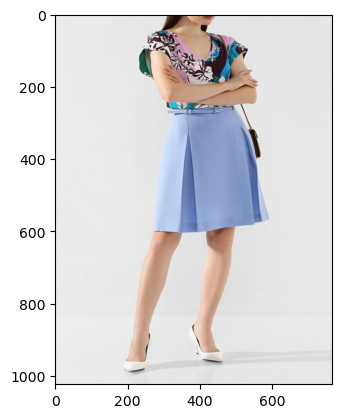

In [21]:
imshow(df.image[0])

In [22]:
tqdm._instances.clear()
images = df['image'].tolist()
images = [copy.deepcopy(arr) for arr in images]
processed_img = [apply_mask(a, b) for a, b in tqdm(zip(images, df['mask_final']))]
df['processed_img'] = processed_img


704it [00:06, 101.63it/s]


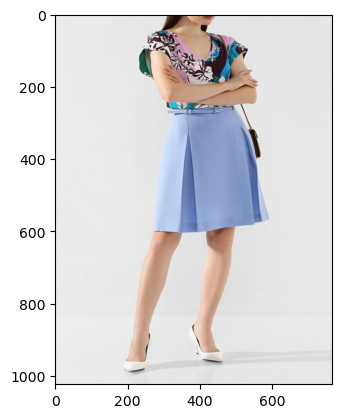

In [23]:
imshow(df.image[0])

In [24]:
# save processed_images to /preprocessed
SAVE_PROCESSED = True
if SAVE_PROCESSED:
    for i, img in tqdm(enumerate(processed_img)):
        img.save('C:/code/python/test_task_big/preprocessed_10/' + df.ids[i] + '.jpg')

704it [00:09, 78.13it/s]


In [25]:
def show_images_df(df, cols, index, cols_per_row=5, save=False):
    try:
        num_images = len(cols)
        num_rows = (num_images + cols_per_row - 1) // cols_per_row
        fig, axes = plt.subplots(num_rows, cols_per_row, figsize=(20, 4*num_rows))
        for i, col in enumerate(cols):
            row = i // cols_per_row
            col_index = i % cols_per_row
            image = df.loc[index, col]
            if not image:
                print(f'no {col} image for index {index}')
                continue
            if num_rows == 1:
                axes[col_index].set_title(col)
                axes[col_index].imshow(image)
                axes[col_index].axis('off')
            else:
                axes[row, col_index].set_title(col)
                axes[row, col_index].imshow(image)
                axes[row, col_index].axis('off')

        # Hide the empty axes
        for i in range(num_images, num_rows*cols_per_row):
            if num_rows == 1:
                axes[i].set_visible(False)
            else:
                row = i // cols_per_row
                col_index = i % cols_per_row
                axes[row, col_index].set_visible(False)

        if save:
            # save as jpg
            plt.savefig('full_outs/' + df.ids[index] + '.jpg')
            plt.close()
        else:
            plt.show()
    except Exception as e:
        # plt.close()
        print(e)


In [26]:
df[df.ids.str.contains('168764')].index

Int64Index([1], dtype='int64')

In [27]:
df[df.ids.str.contains('178842')].index

Int64Index([229], dtype='int64')

In [28]:
df.columns

Index(['image', 'human_parsing', 'pose_img', 'pose_json', 'ids',
       'pose_keypoints', 'left_ankles', 'right_ankles', 'mask_shorts',
       'mask_legs', 'mask_shirts', 'mask_hands', 'mask_ankle', 'boxes_shorts',
       'mask_prolonged_shorts', 'left_ankles_anchors', 'right_ankles_anchors',
       'mask_left_ankle', 'mask_right_ankle', 'mask_shorts_ankles',
       'mask_shorts_ankles_legs', 'mask_final', 'processed_img'],
      dtype='object')

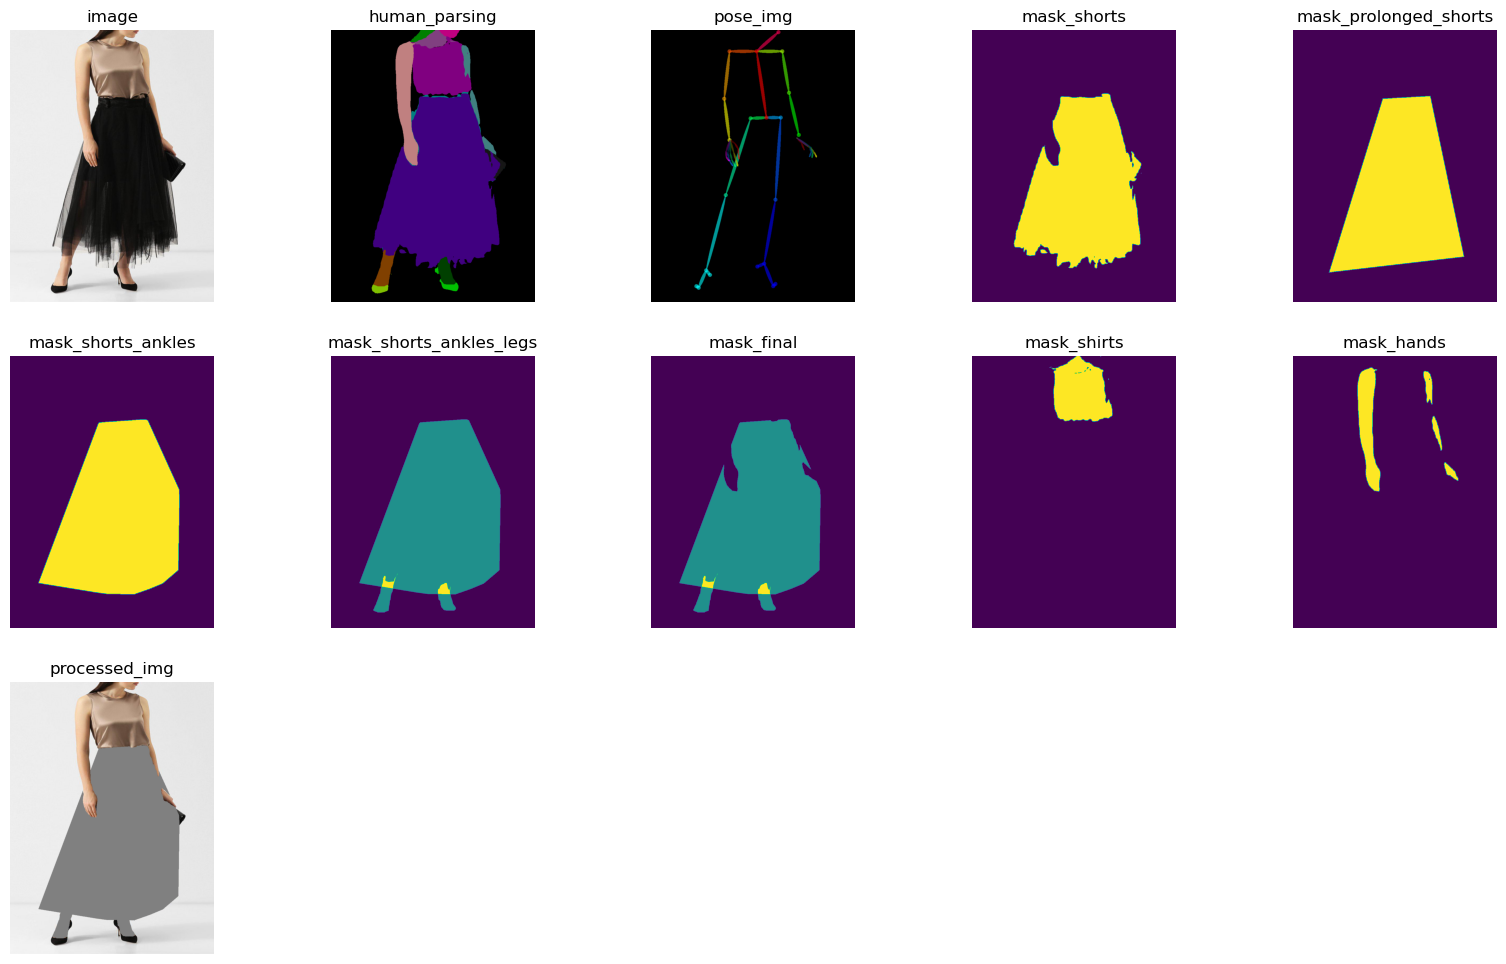

In [29]:
img_cols = ['image', 'human_parsing', 'pose_img', 'mask_shorts', 'mask_prolonged_shorts', 'mask_shorts_ankles', 'mask_shorts_ankles_legs', 'mask_final', 'mask_shirts','mask_hands', 'processed_img']
show_images_df(df, img_cols, 8)

In [30]:
# tqdm._instances.clear()
# Parallel(n_jobs=-1)(
#     delayed(show_images_df)(df, img_cols, i, save=True) for i in tqdm(range(len(df)))
# )

 11%|█▏        | 80/704 [01:49<12:19,  1.19s/it]

Image data of dtype object cannot be converted to float


 18%|█▊        | 128/704 [02:53<09:35,  1.00it/s]

Image data of dtype object cannot be converted to float


 38%|███▊      | 266/704 [05:43<05:45,  1.27it/s]

Image data of dtype object cannot be converted to float


 51%|█████     | 356/704 [07:31<04:28,  1.30it/s]

Image data of dtype object cannot be converted to float


 58%|█████▊    | 407/704 [08:35<05:07,  1.04s/it]

Image data of dtype object cannot be converted to float


 70%|███████   | 493/704 [10:13<02:50,  1.24it/s]

Image data of dtype object cannot be converted to float


 79%|███████▉  | 557/704 [11:23<01:54,  1.29it/s]

Image data of dtype object cannot be converted to float


 83%|████████▎ | 587/704 [11:54<01:36,  1.22it/s]

Image data of dtype object cannot be converted to float


 87%|████████▋ | 612/704 [12:25<01:13,  1.25it/s]

Image data of dtype object cannot be converted to float


 89%|████████▉ | 627/704 [12:40<01:02,  1.24it/s]

Image data of dtype object cannot be converted to float


 92%|█████████▏| 647/704 [13:01<00:47,  1.20it/s]

Image data of dtype object cannot be converted to float


 96%|█████████▌| 674/704 [13:30<00:25,  1.20it/s]

Image data of dtype object cannot be converted to float


 96%|█████████▌| 677/704 [13:33<00:19,  1.37it/s]

Image data of dtype object cannot be converted to float


 97%|█████████▋| 683/704 [13:38<00:15,  1.37it/s]

Image data of dtype object cannot be converted to float


100%|█████████▉| 701/704 [13:57<00:02,  1.17it/s]

Image data of dtype object cannot be converted to float


100%|██████████| 704/704 [14:00<00:00,  1.19s/it]


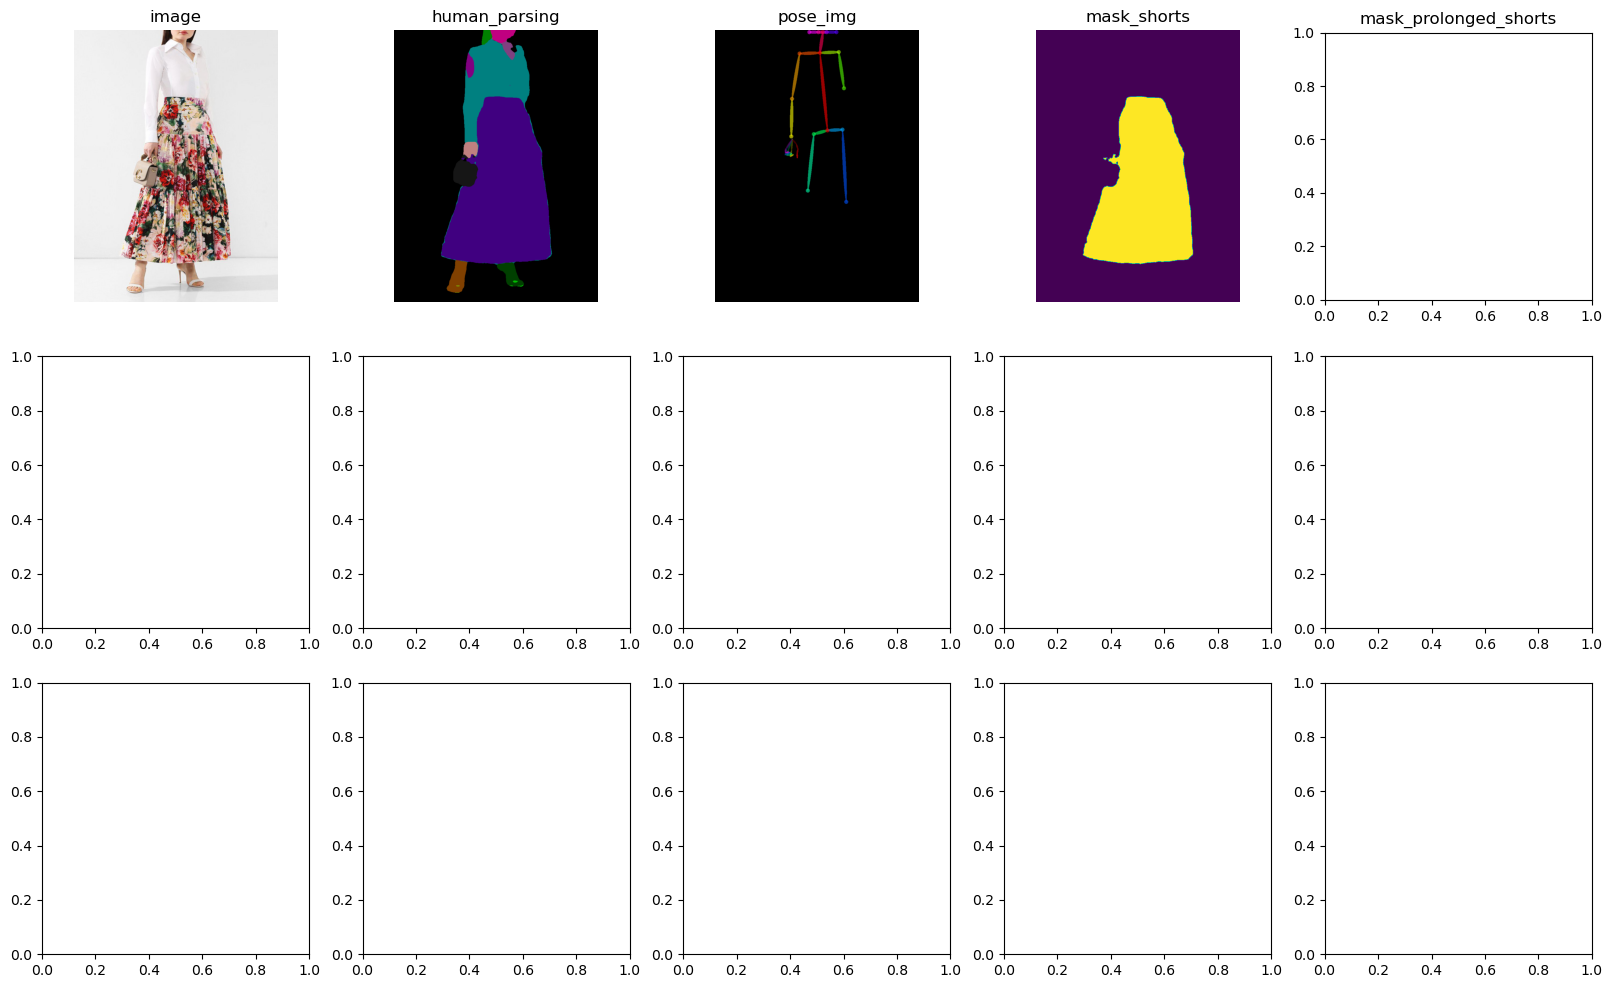

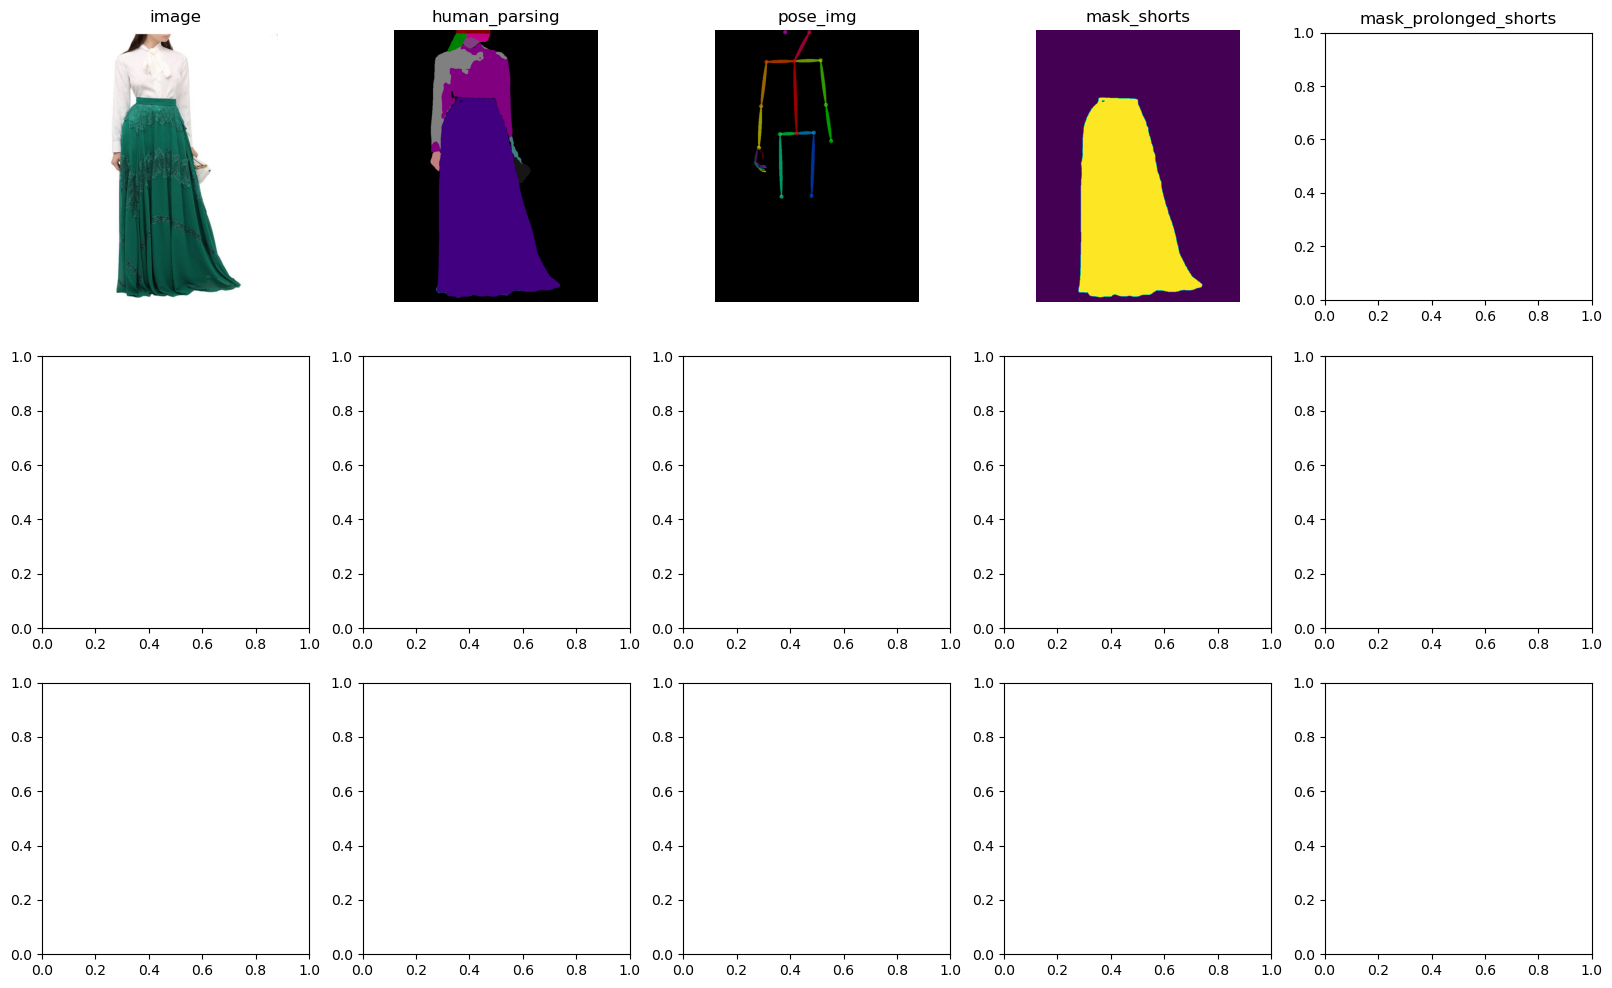

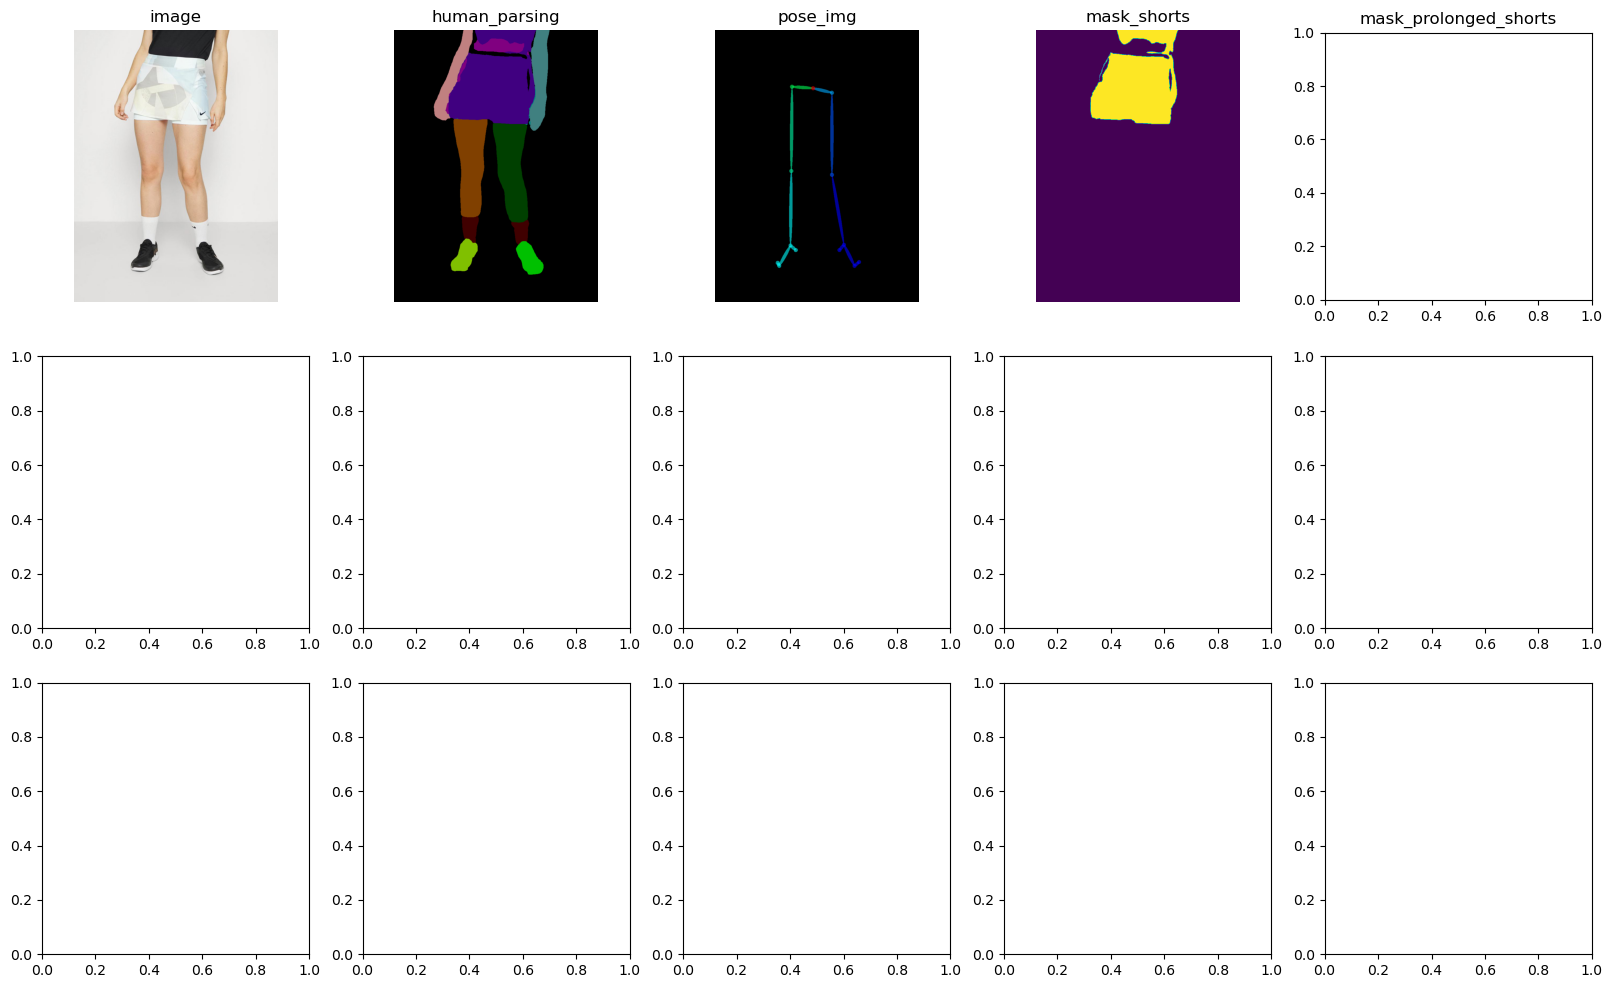

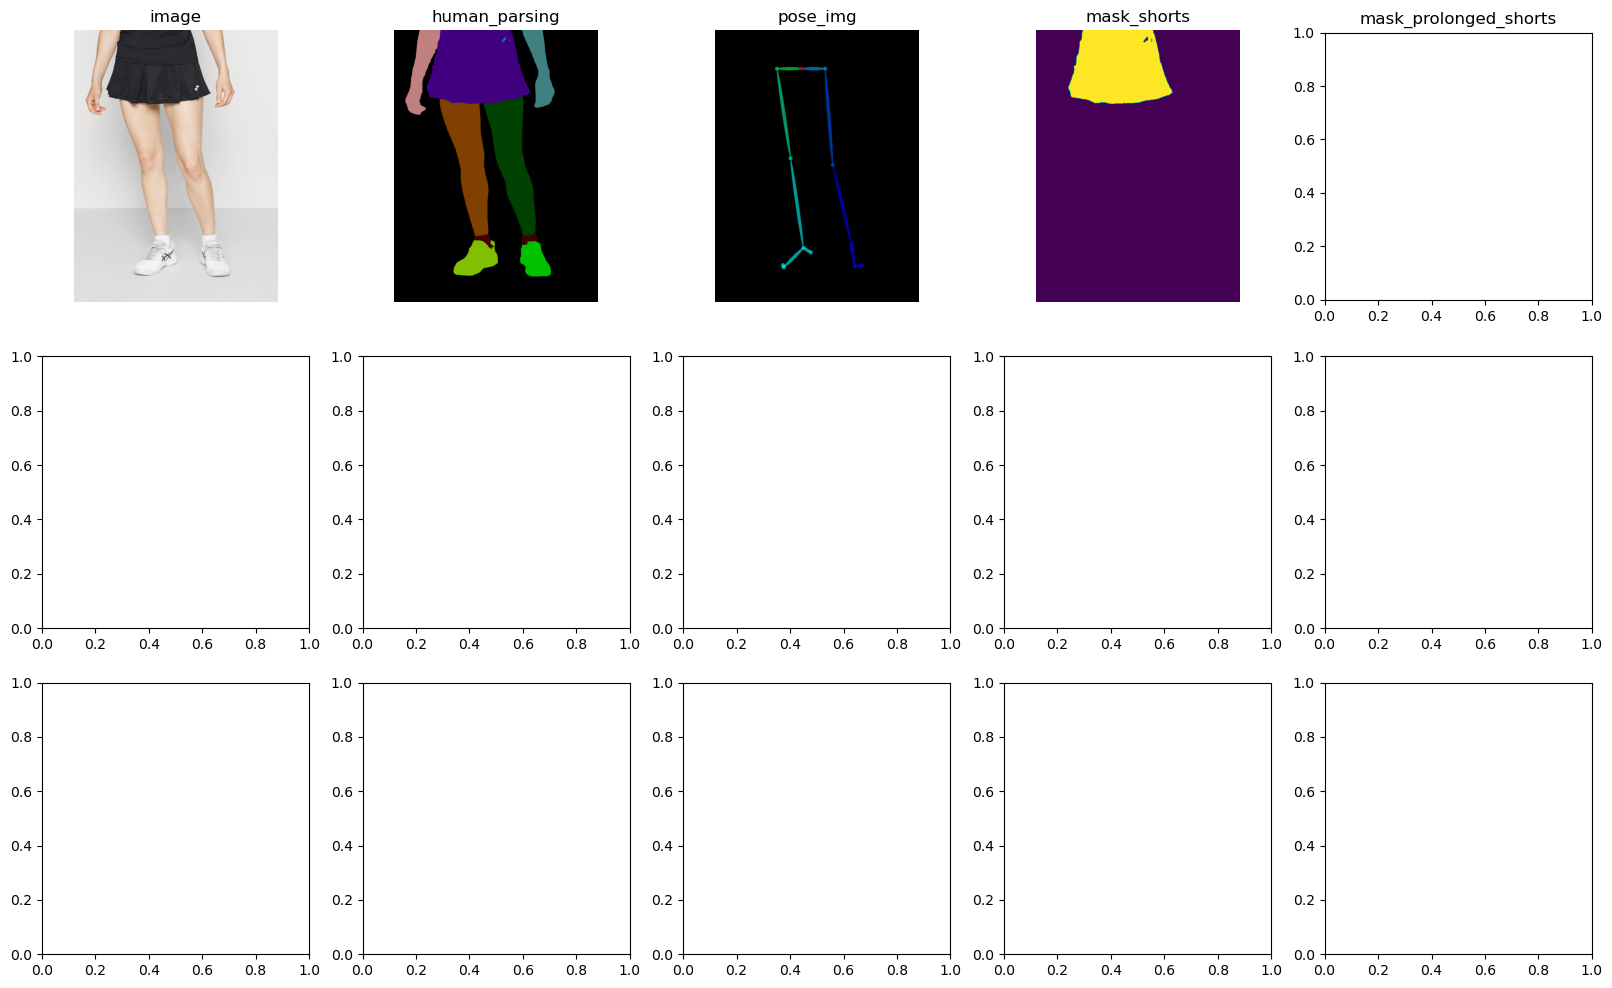

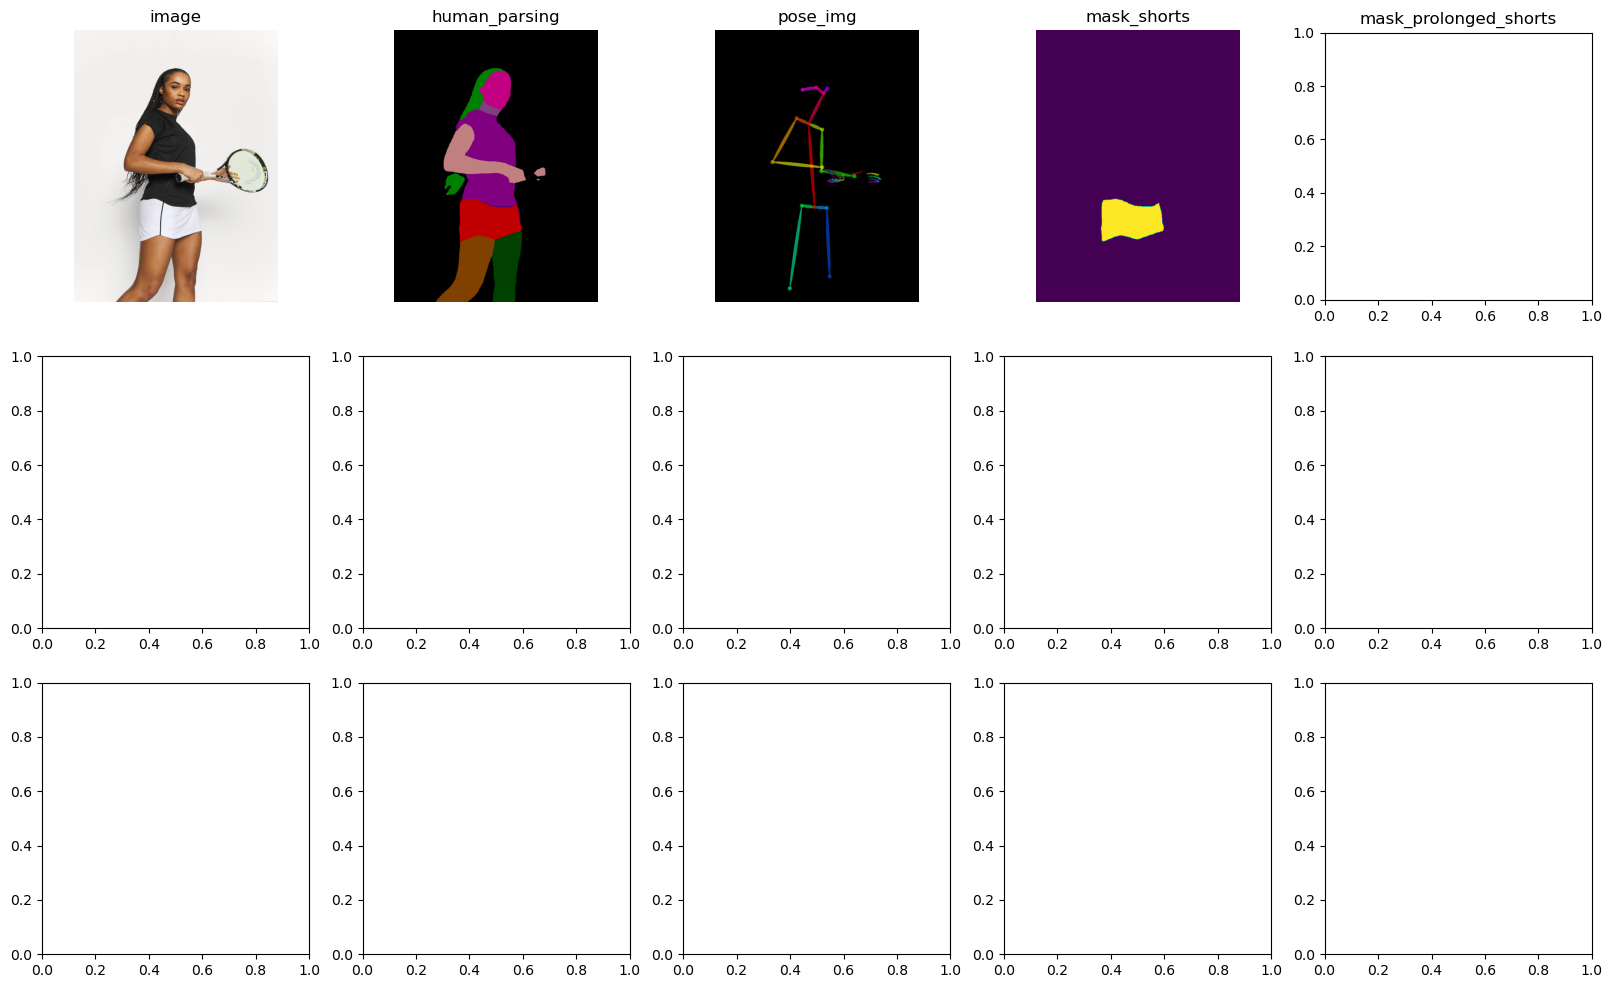

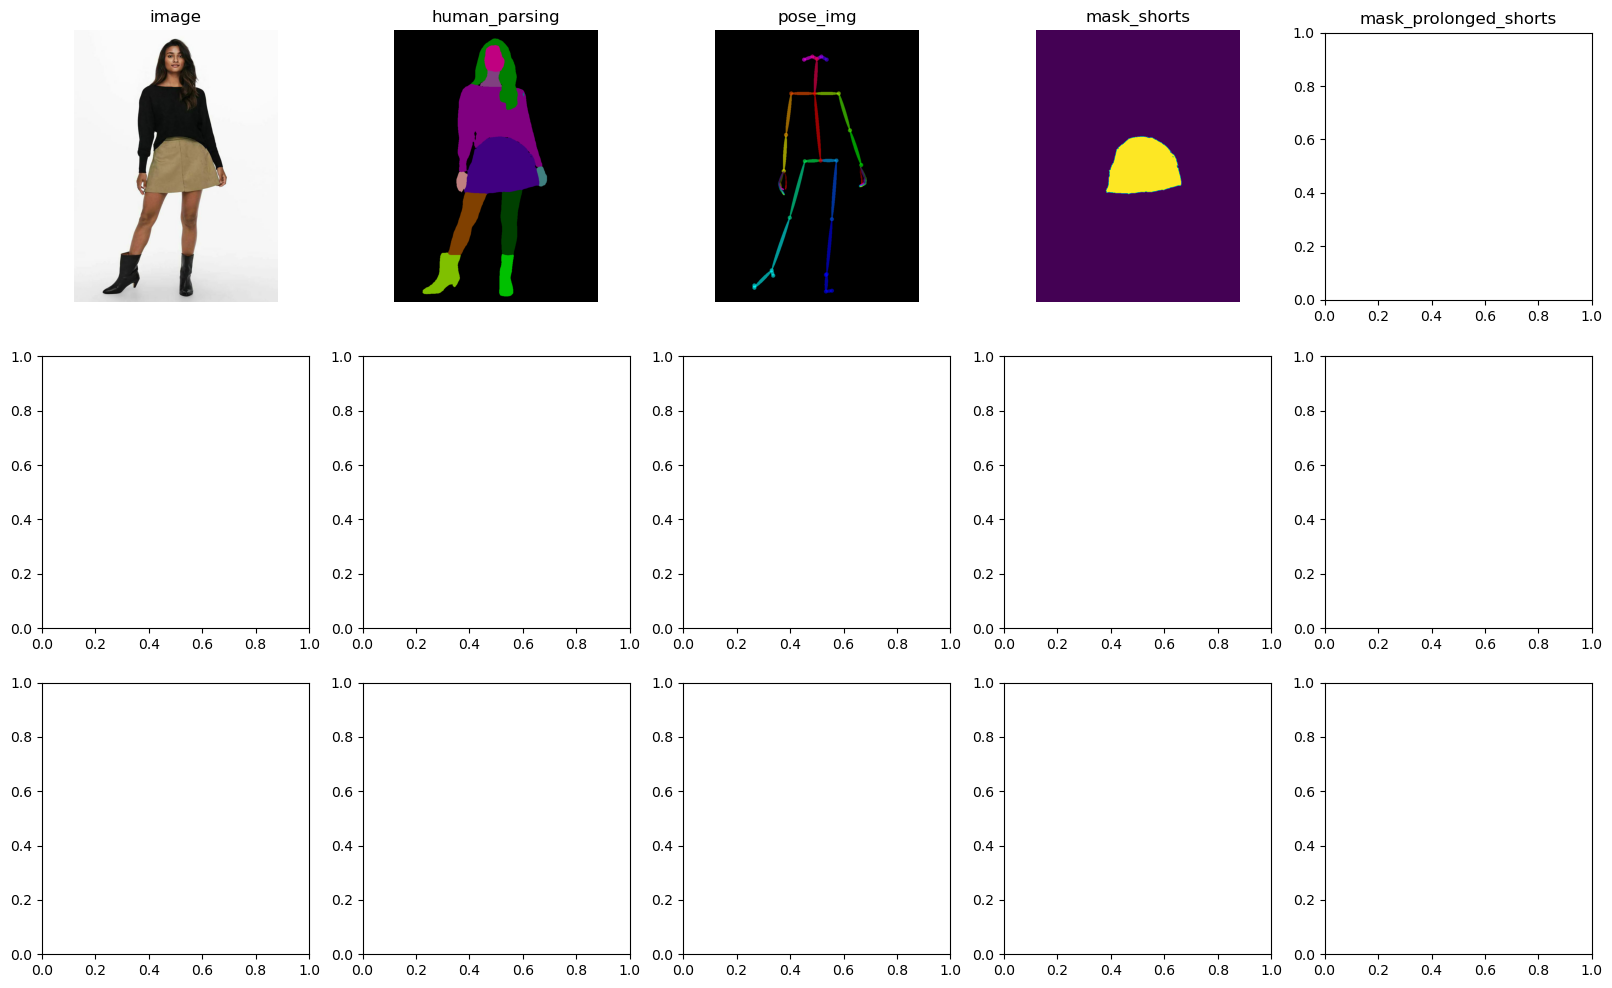

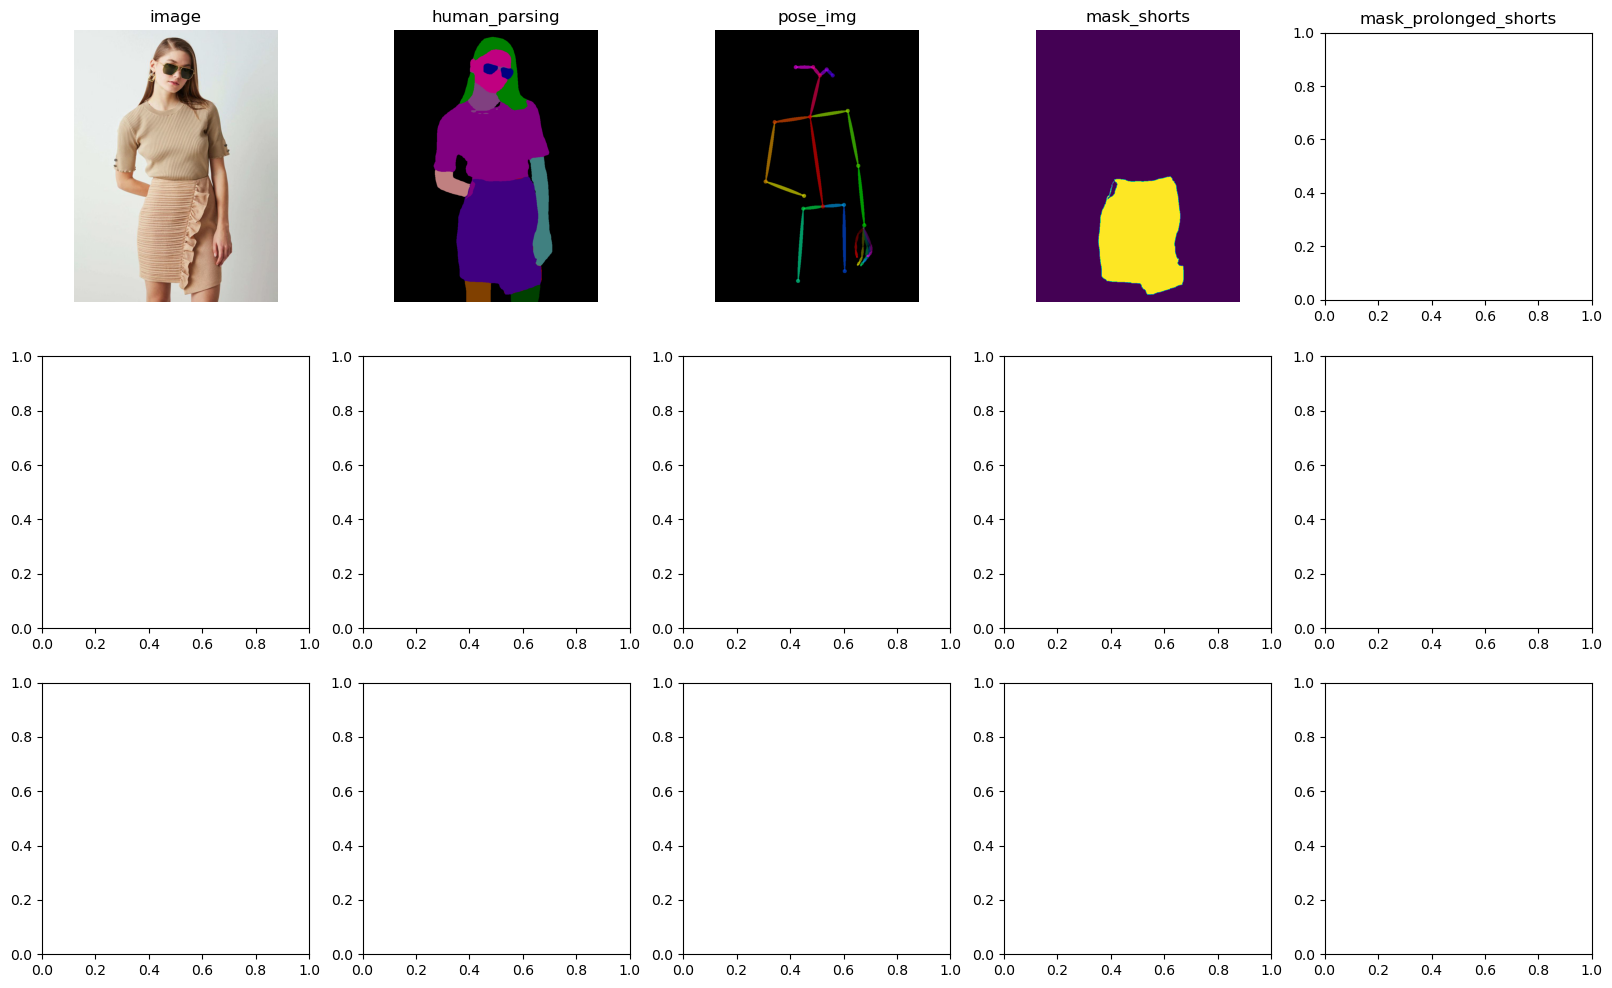

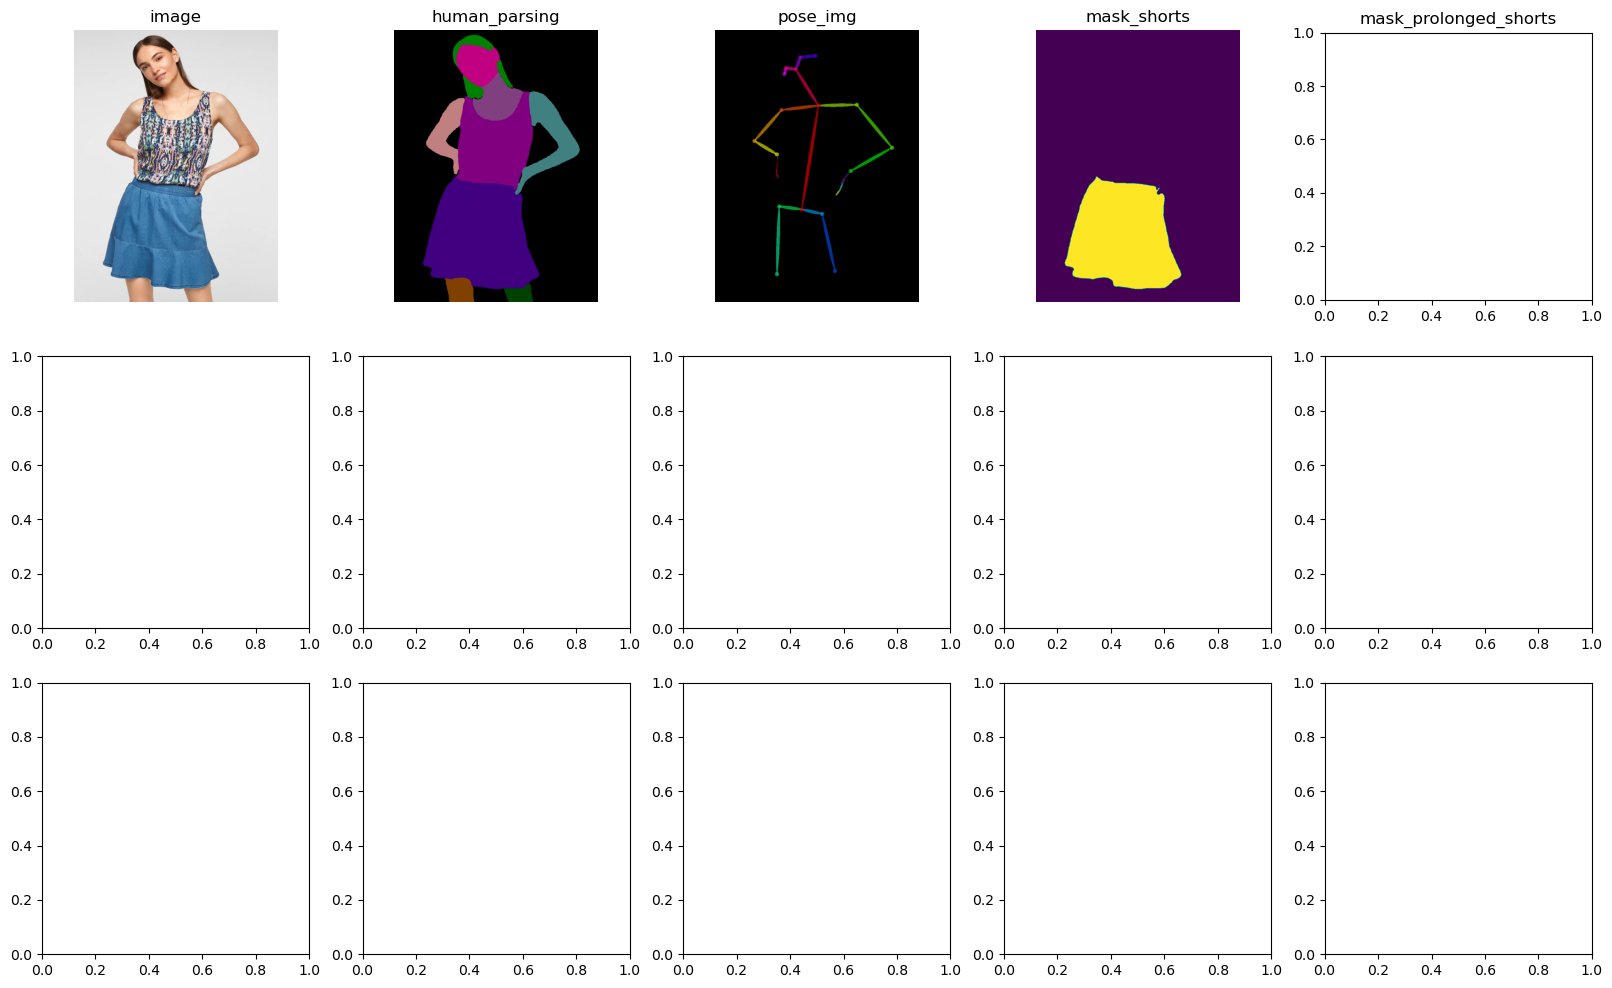

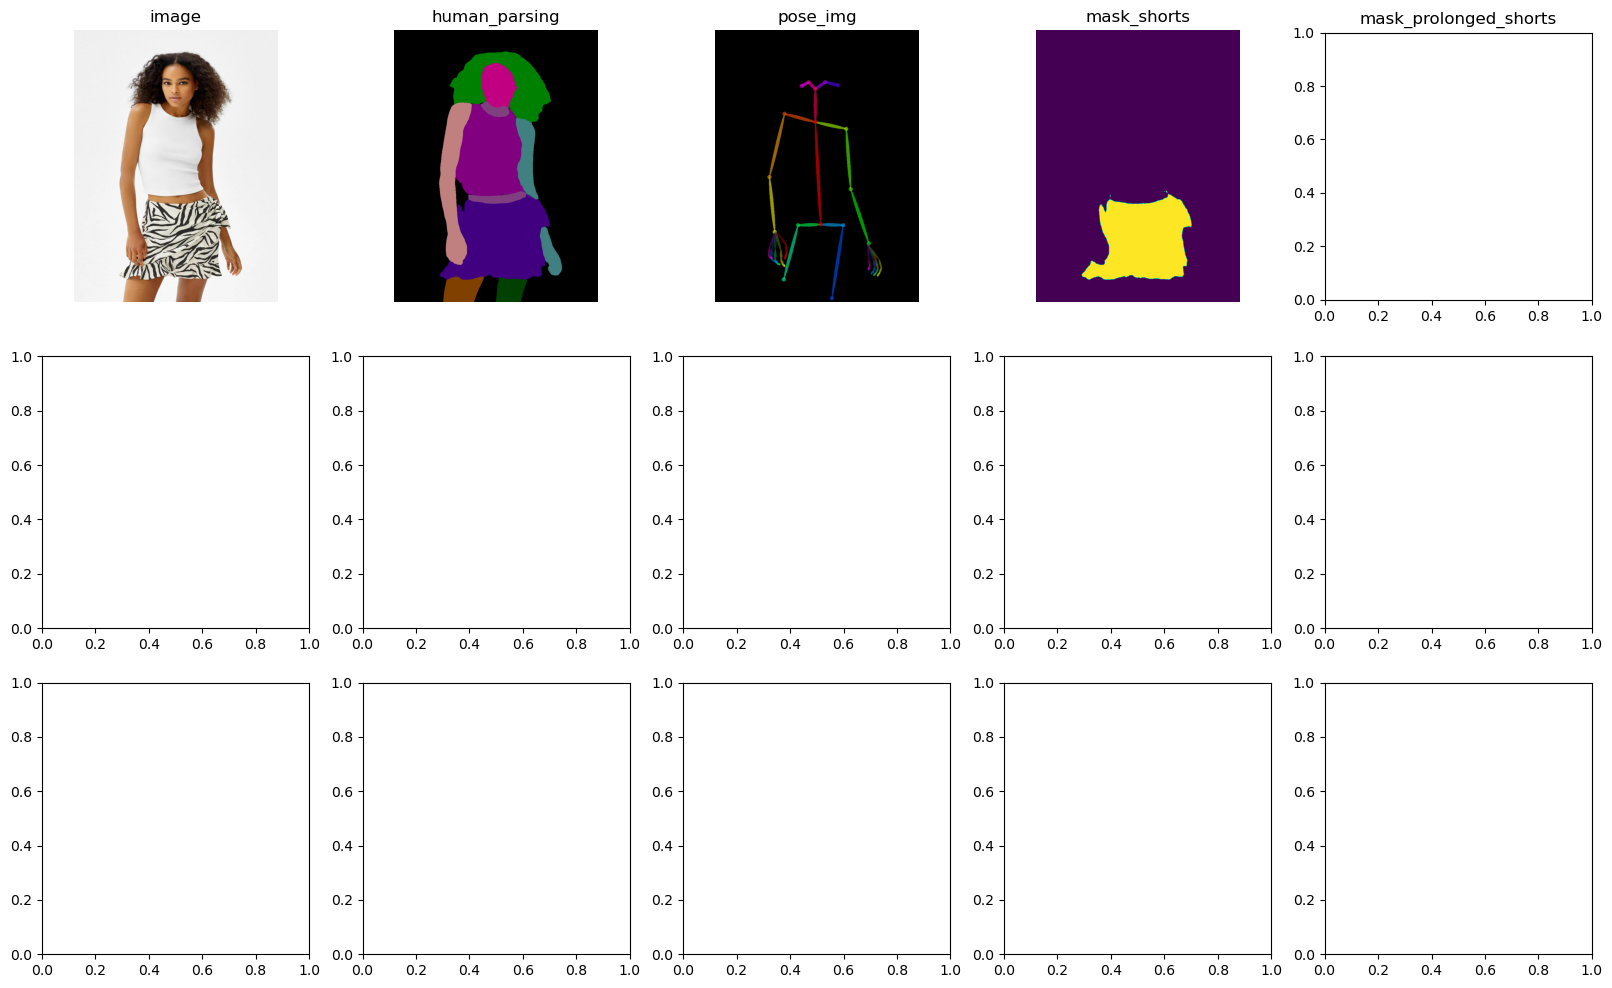

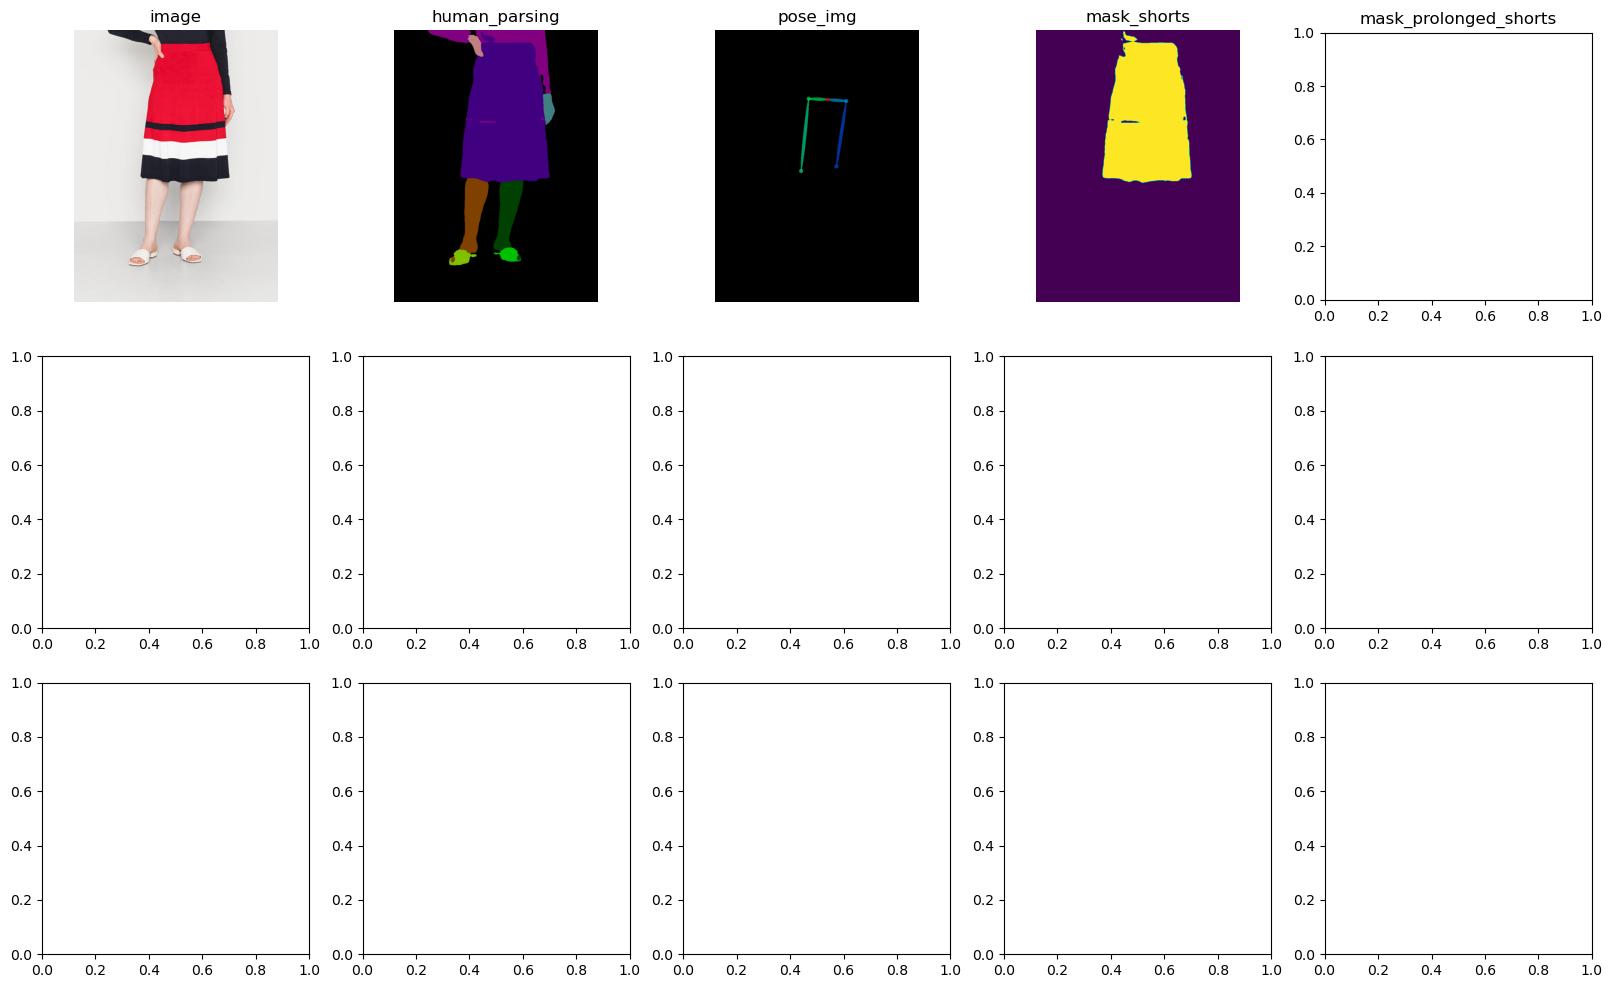

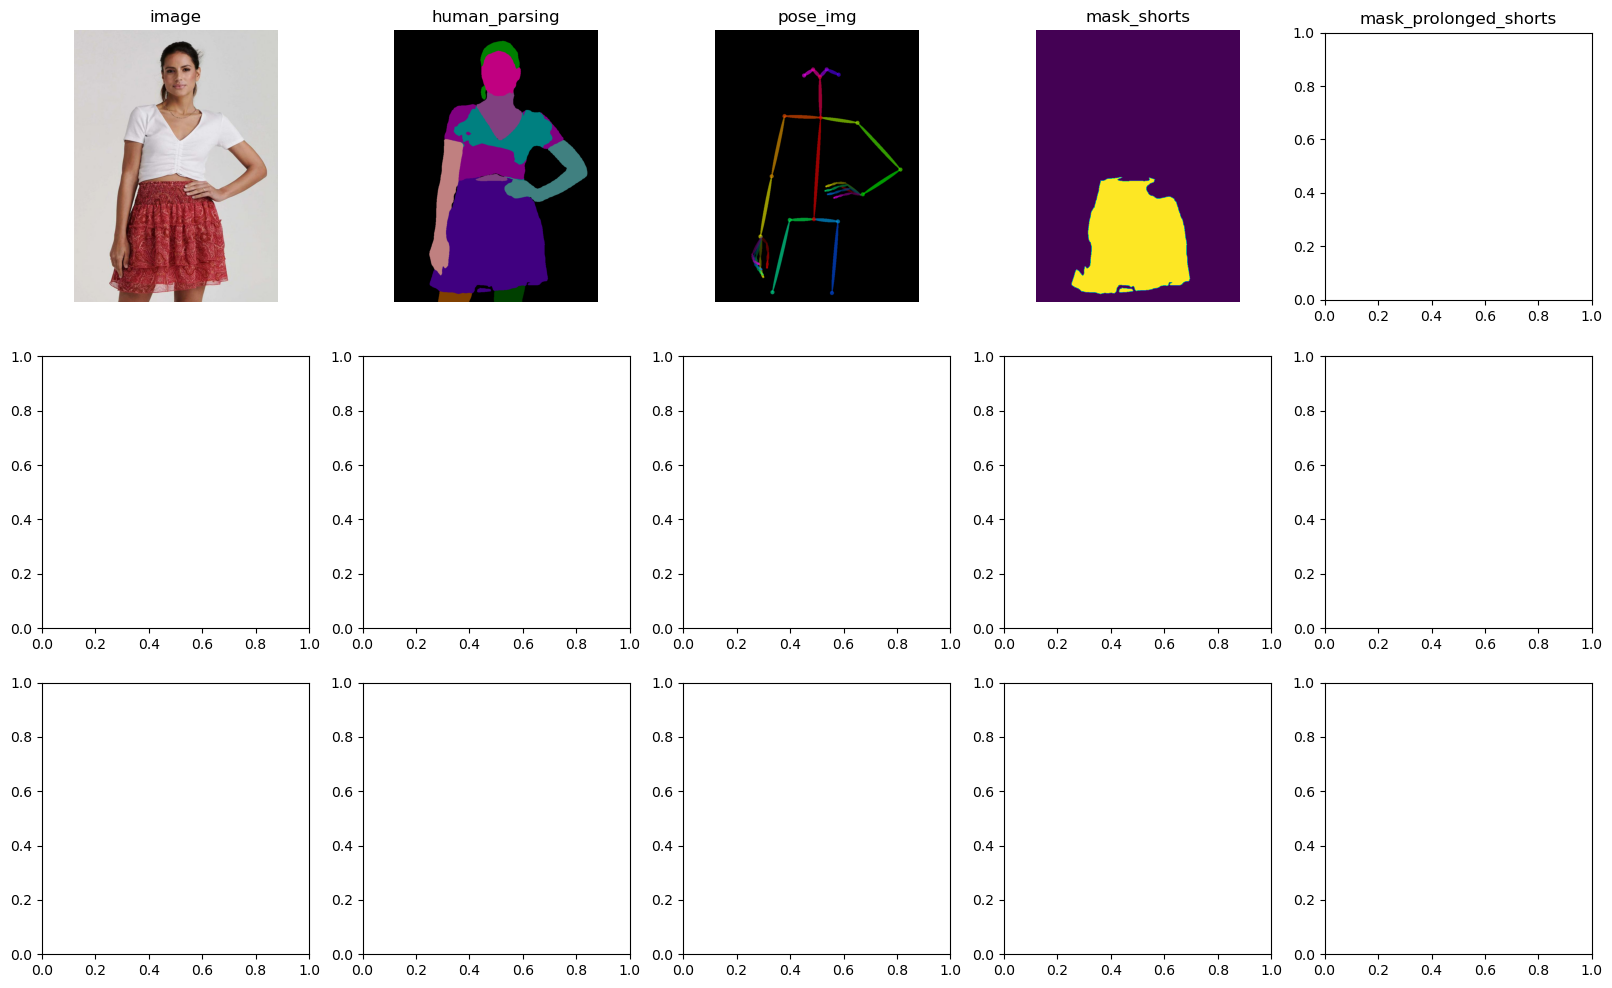

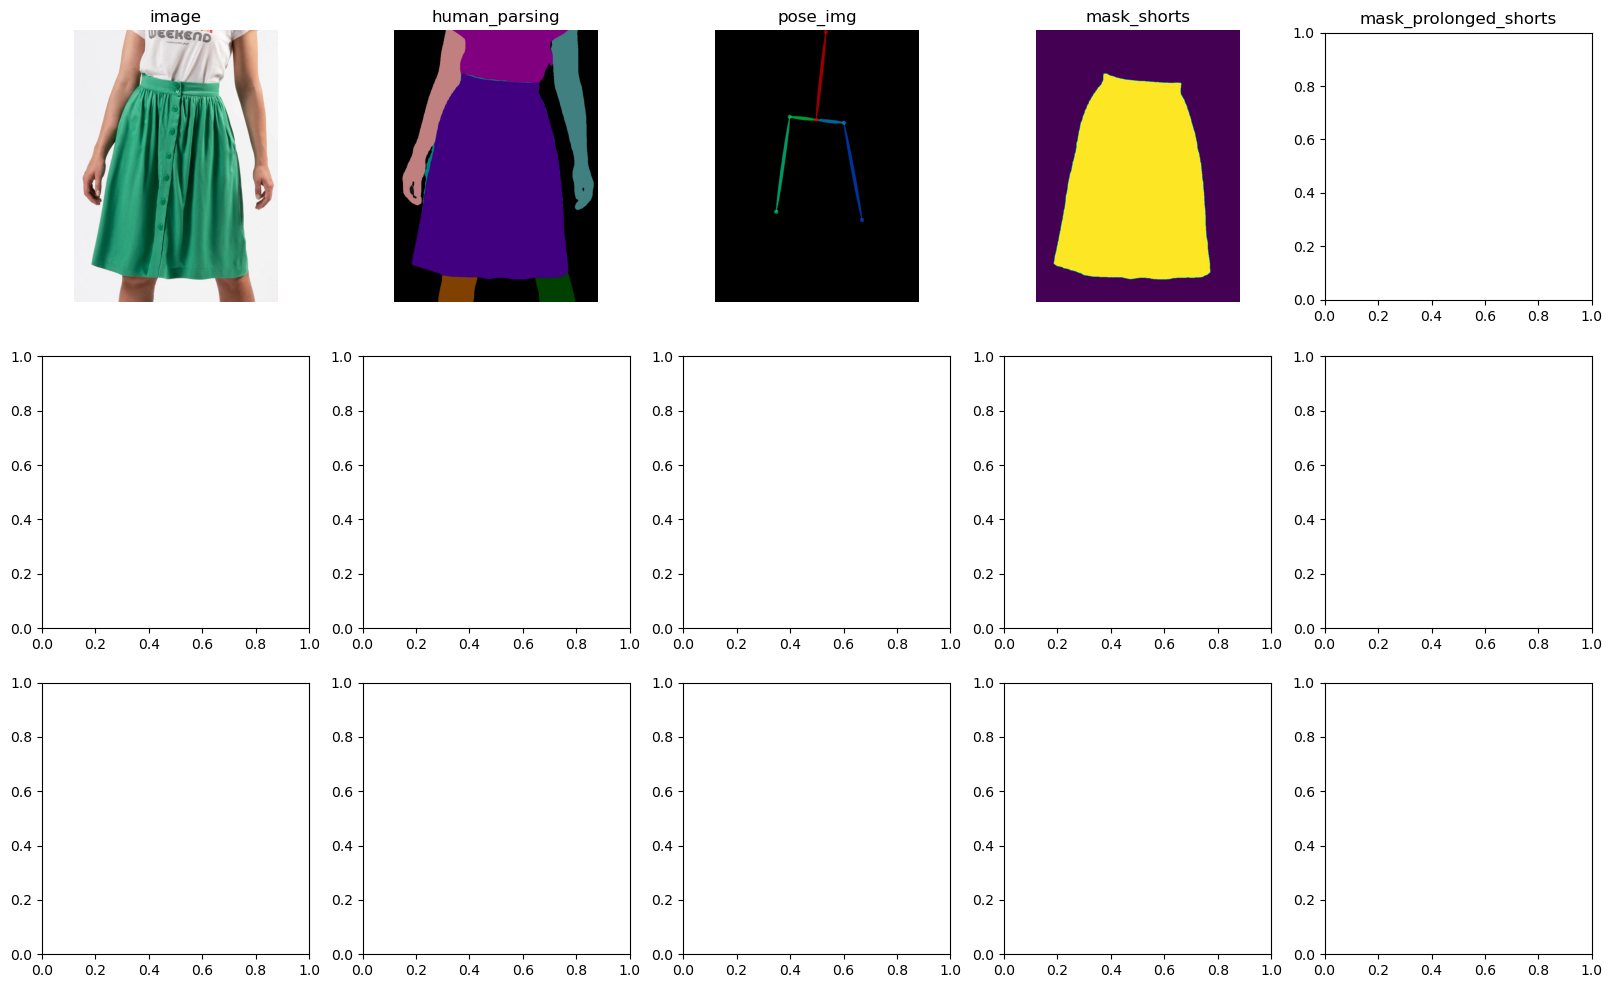

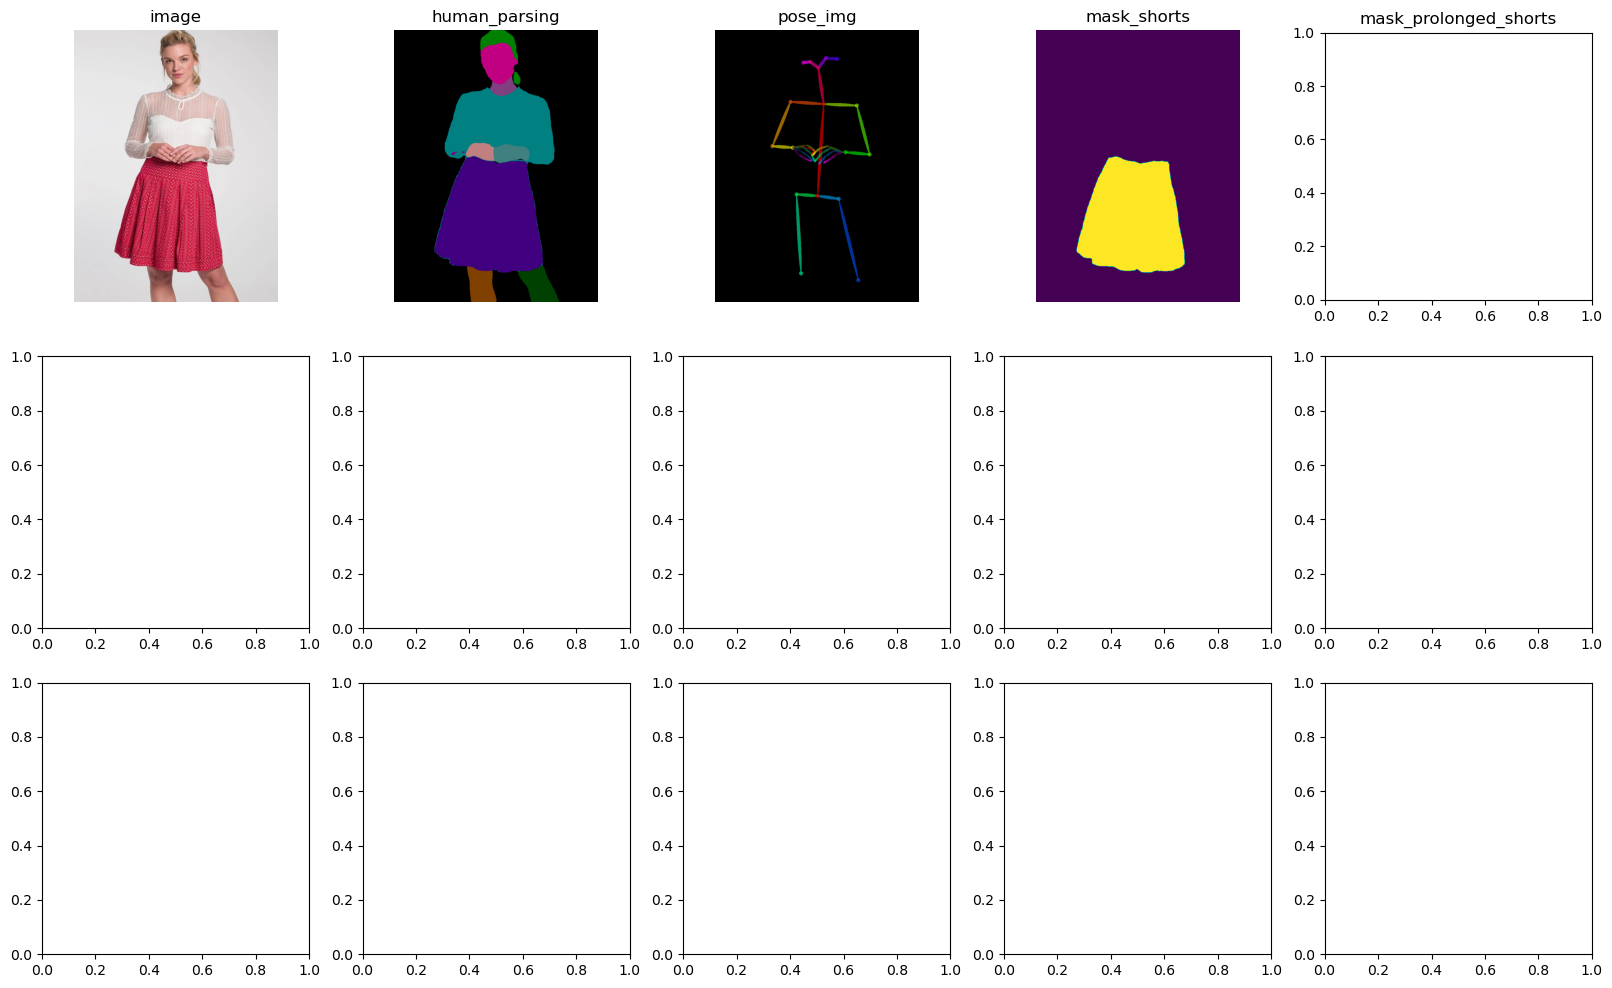

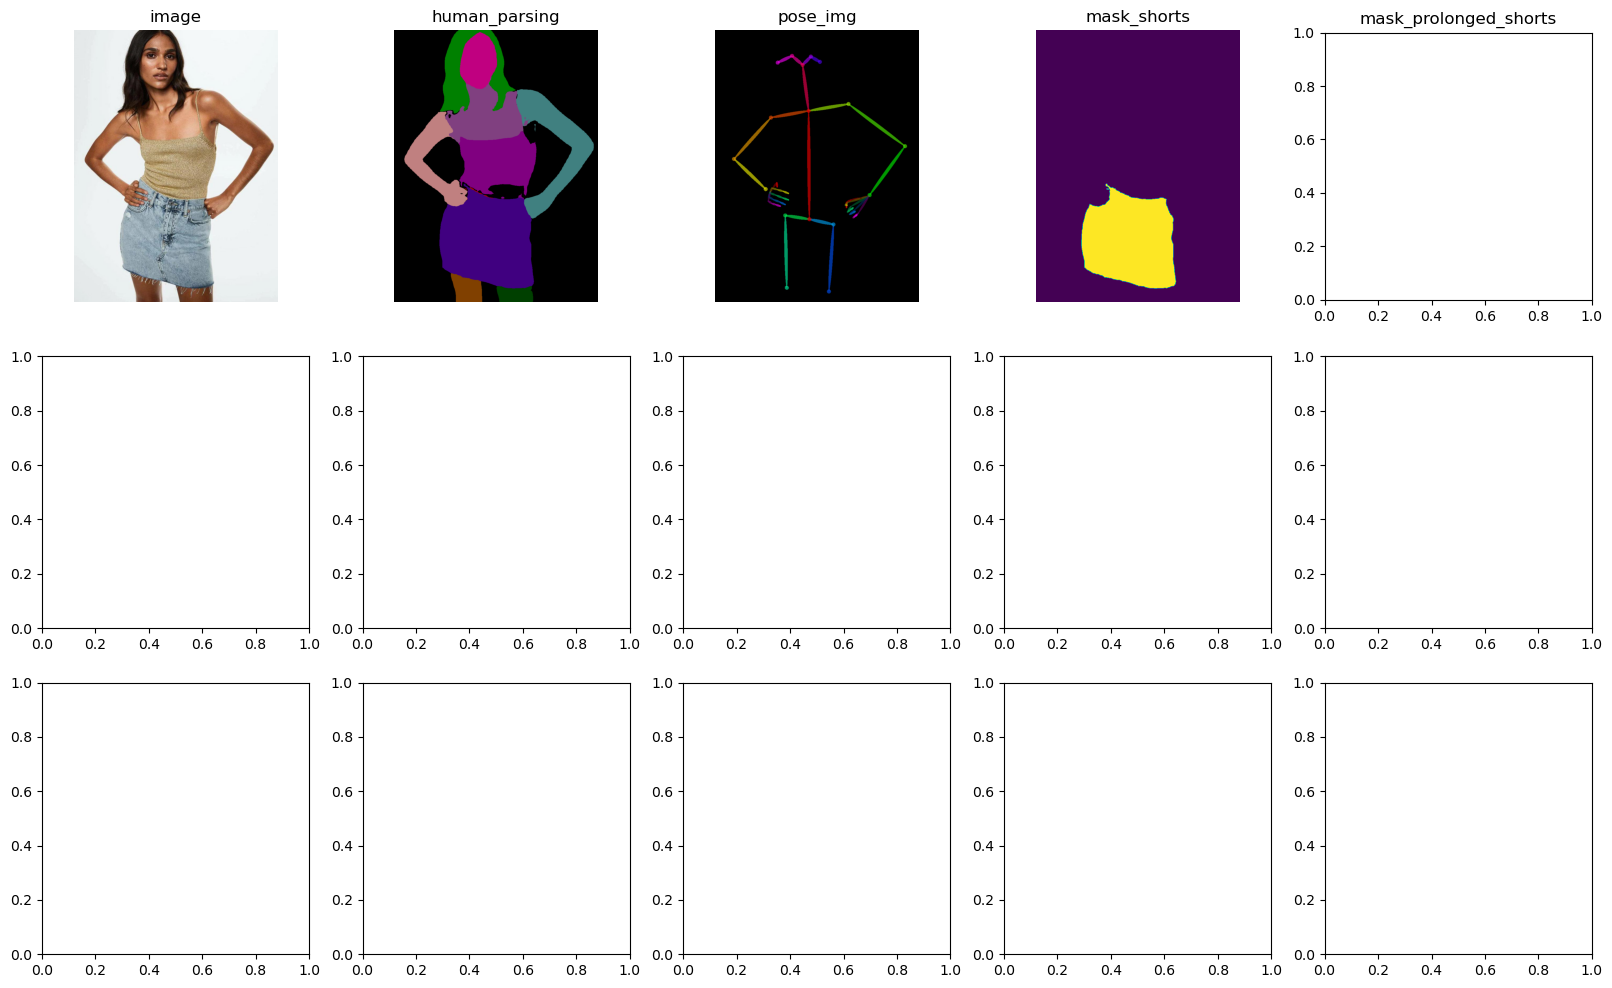

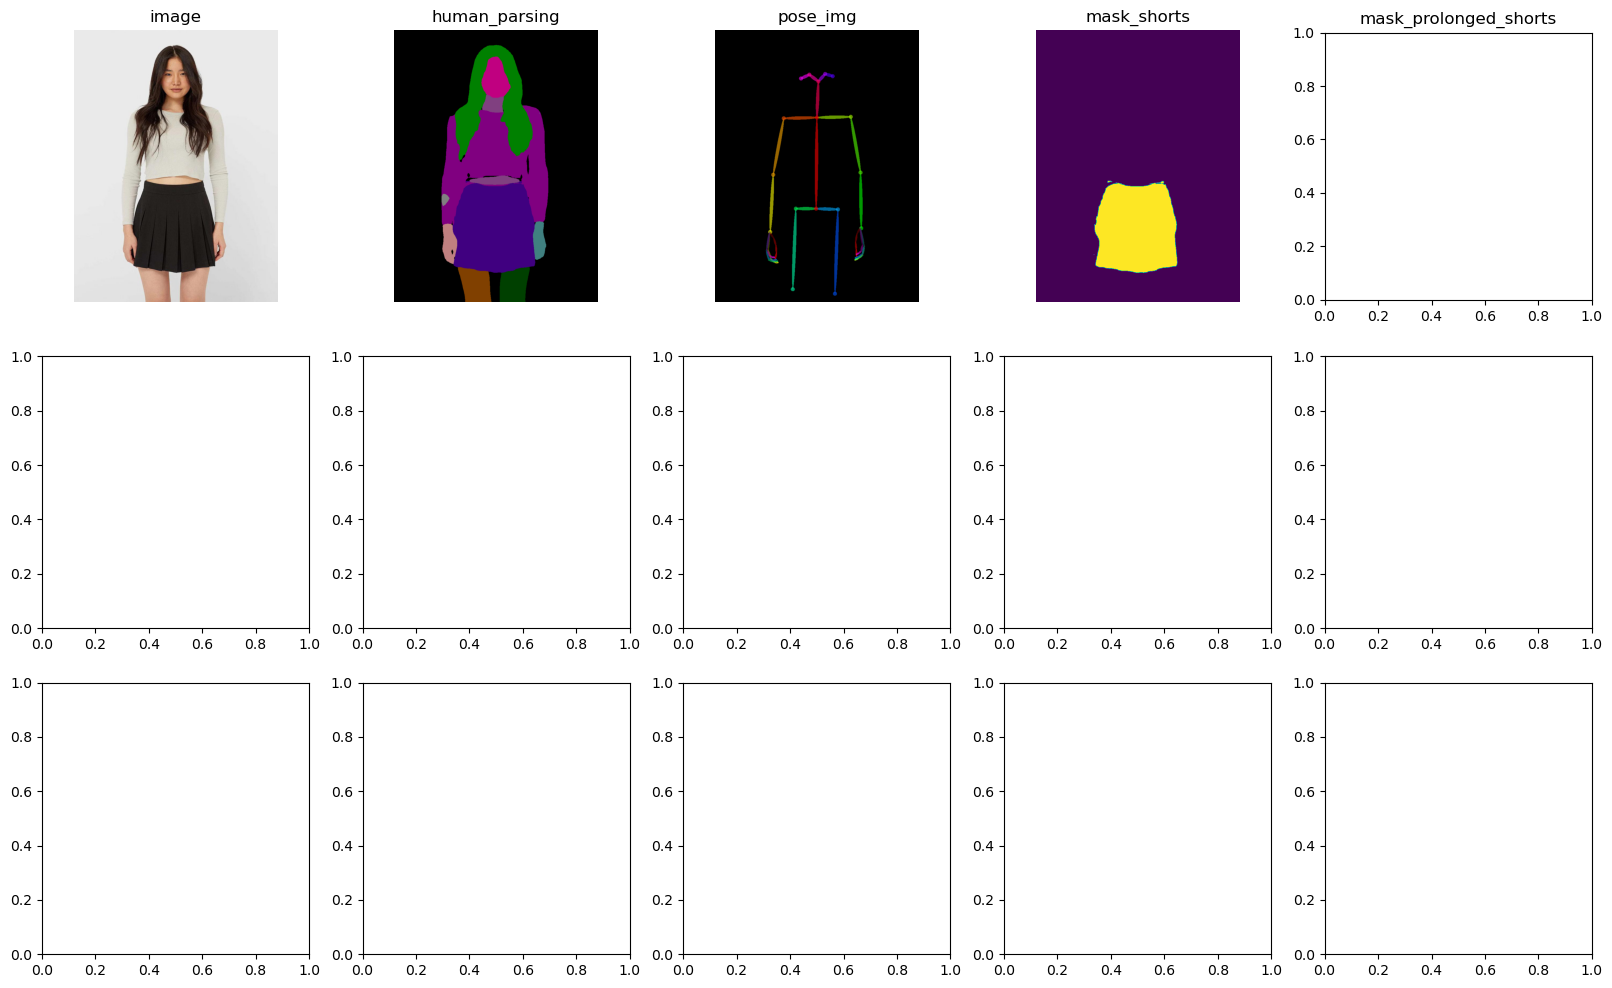

In [31]:
for i in tqdm(range(len(df))):
    show_images_df(df, img_cols, i, save=True)

In [32]:
# HELPER FUNCTIONS
# def draw_pose(img, poses):
#     draw = ImageDraw.Draw(img)
#     for i in range(0, len(poses), 3):
#         draw.ellipse((poses[i]-5, poses[i+1]-5, poses[i]+5, poses[i+1]+5), fill=(255, 0, 0, 255))
#         draw.text((poses[i], poses[i+1]), str(i//3), fill=(255, 0, 0, 0), font= ImageFont.truetype("arial.ttf", 30))
#     return img
# draw_pose(df.image[0], df.pose_keypoints[0])